## Basic operations with Atmospheric data on native grid

In [1]:
from dask.distributed import Client
client = Client(scheduler_file='/proj/eunbyeol/MPI/scheduler.json')  
client

<Client: 'tcp://203.247.189.224:42851' processes=7 threads=126, memory=586.73 GiB>

In [2]:
import xarray as xr
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from dask.diagnostics import ProgressBar
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmcrameri.cm as cm 

In [4]:
model = 'awicm3'
expid = 'TCo1279-DART' 
version = '2080C'
realm = 'oifs'
base_f = f"/scratch/{model}/{expid}-{version}/outdata/{realm}/"


In [5]:
model = 'awicm3'
expid = 'TCo1279-DART' 
version = '1950C'
realm = 'oifs'
base_p = f"/scratch/{model}/{expid}-{version}/outdata/{realm}/"

In [6]:
# -------------------
# 1) YEAR RANGE FUNCTION (FIXED)
# -------------------
def extract_year_range(fname):
    m = re.search(r'_(\d{6})-(\d{6})\.nc$', fname)
    if m:
        y1 = int(m.group(1)[0:4])
        y2 = int(m.group(2)[0:4])
        return y1, y2
    return None, None   

In [7]:
# -------------------
# 2) Get file list
# -------------------
files_f = os.listdir(base_f)
files_p = os.listdir(base_p)
# -------------------
# 3) Target variable
# -------------------
target = "1d_2t"
var_key = target.split("_", 1)[1]   # "2t"

In [8]:
# -------------------
# 4) Select files by year
# -------------------
p_start_year = 1950
p_end_year = 1959

ds_files_p = sorted([f for f in files_p if target in f])

selected_files_p = []

for f in ds_files_p:
    y1, y2 = extract_year_range(f)
    if y1 is None:
        continue
    if (y2 >= p_start_year) and (y1 <= p_end_year):
        selected_files_p.append(os.path.join(base_p, f))
      

In [9]:
selected_files_p

['/scratch/awicm3/TCo1279-DART-1950C/outdata/oifs/atm_reduced_1d_2t_1d_195001-195001.nc',
 '/scratch/awicm3/TCo1279-DART-1950C/outdata/oifs/atm_reduced_1d_2t_1d_195002-195002.nc',
 '/scratch/awicm3/TCo1279-DART-1950C/outdata/oifs/atm_reduced_1d_2t_1d_195003-195003.nc',
 '/scratch/awicm3/TCo1279-DART-1950C/outdata/oifs/atm_reduced_1d_2t_1d_195004-195004.nc',
 '/scratch/awicm3/TCo1279-DART-1950C/outdata/oifs/atm_reduced_1d_2t_1d_195005-195005.nc',
 '/scratch/awicm3/TCo1279-DART-1950C/outdata/oifs/atm_reduced_1d_2t_1d_195006-195006.nc',
 '/scratch/awicm3/TCo1279-DART-1950C/outdata/oifs/atm_reduced_1d_2t_1d_195007-195007.nc',
 '/scratch/awicm3/TCo1279-DART-1950C/outdata/oifs/atm_reduced_1d_2t_1d_195008-195008.nc',
 '/scratch/awicm3/TCo1279-DART-1950C/outdata/oifs/atm_reduced_1d_2t_1d_195009-195009.nc',
 '/scratch/awicm3/TCo1279-DART-1950C/outdata/oifs/atm_reduced_1d_2t_1d_195010-195010.nc',
 '/scratch/awicm3/TCo1279-DART-1950C/outdata/oifs/atm_reduced_1d_2t_1d_195011-195011.nc',
 '/scratch

In [10]:
f_start_year = 2080
f_end_year = 2089

ds_files_f = sorted([f for f in files_f if target in f])

selected_files_f = []

for f in ds_files_f:
    y1, y2 = extract_year_range(f)
    if y1 is None:
        continue
    if (y2 >= f_start_year) and (y1 <= f_end_year):
        selected_files_f.append(os.path.join(base_f, f))

# print("Selected files:", selected_files)

In [11]:
selected_files_f

['/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208001-208001.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208002-208002.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208003-208003.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208004-208004.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208005-208005.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208006-208006.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208007-208007.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208008-208008.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208009-208009.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208010-208010.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208011-208011.nc',
 '/scratch

In [12]:
# -------------------
# 5) Open dataset (FIXED)
# -------------------
ds_p = xr.open_mfdataset(
    selected_files_p,
    combine='by_coords',
    parallel=True,
    chunks={"time": 100},
)

print(ds_p)

<xarray.Dataset> Size: 868GB
Dimensions:               (time_counter: 3652, cell: 6599680, nvertex: 4,
                           axis_nbounds: 2)
Coordinates:
    lat                   (cell) float32 26MB dask.array<chunksize=(6599680,), meta=np.ndarray>
    lon                   (cell) float32 26MB dask.array<chunksize=(6599680,), meta=np.ndarray>
    time_centered         (time_counter) datetime64[ns] 29kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 29kB 1950-01-01T12:00...
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables:
    bounds_lon            (time_counter, cell, nvertex) float32 386GB dask.array<chunksize=(31, 6599680, 4), meta=np.ndarray>
    bounds_lat            (time_counter, cell, nvertex) float32 386GB dask.array<chunksize=(31, 6599680, 4), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 58kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_coun

2025-12-01 15:26:47,019 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [13]:
# -------------------
# 5) Open dataset (FIXED)
# -------------------
ds_f = xr.open_mfdataset(
    selected_files_f,
    combine='by_coords',
    parallel=True,
    chunks={"time": 100},
)

print(ds_f)

<xarray.Dataset> Size: 868GB
Dimensions:               (time_counter: 3653, cell: 6599680, nvertex: 4,
                           axis_nbounds: 2)
Coordinates:
    lat                   (cell) float32 26MB dask.array<chunksize=(6599680,), meta=np.ndarray>
    lon                   (cell) float32 26MB dask.array<chunksize=(6599680,), meta=np.ndarray>
    time_centered         (time_counter) datetime64[ns] 29kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 29kB 2080-01-01T12:00...
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables:
    bounds_lon            (time_counter, cell, nvertex) float32 386GB dask.array<chunksize=(31, 6599680, 4), meta=np.ndarray>
    bounds_lat            (time_counter, cell, nvertex) float32 386GB dask.array<chunksize=(31, 6599680, 4), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 58kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_coun

In [14]:
# -------------------
# 6) Variable load
# -------------------
if var_key not in ds_p:
    raise KeyError(f"Variable {var_key} not found. Available: {list(ds.data_vars.keys())}")

da_p = ds_p[var_key]

# -------------------
# 7) Select by time
# -------------------
time_dim = "time_counter" if "time_counter" in da_p.dims else "time"

da_sel_p = da_p.sel({time_dim: slice(f"{p_start_year}-01-01", f"{p_end_year}-12-31")})

In [15]:
# -------------------
# 6) Variable load
# -------------------
if var_key not in ds_f:
    raise KeyError(f"Variable {var_key} not found. Available: {list(ds.data_vars.keys())}")

da_f = ds_f[var_key]

# -------------------
# 7) Select by time
# -------------------
time_dim = "time_counter" if "time_counter" in da_f.dims else "time"

da_sel_f = da_f.sel({time_dim: slice(f"{f_start_year}-01-01", f"{f_end_year}-12-31")})

In [16]:
# -------------------
# 8) Mean
# -------------------
with ProgressBar():
    da_mean_p = da_sel_p.mean(dim=time_dim).compute()

print(da_mean_p)

<xarray.DataArray '2t' (cell: 6599680)> Size: 26MB
array([252.56026, 252.56648, 252.57191, ..., 226.10922, 226.199  ,
       226.2675 ], dtype=float32)
Coordinates:
    lat      (cell) float32 26MB 89.95 89.95 89.95 ... -89.95 -89.95 -89.95
    lon      (cell) float32 26MB 0.0 18.0 36.0 54.0 ... 288.0 306.0 324.0 342.0
Dimensions without coordinates: cell


In [17]:
# -------------------
# 8) Mean
# -------------------
with ProgressBar():
    da_mean_f = da_sel_f.mean(dim=time_dim).compute()

print(da_mean_f)

<xarray.DataArray '2t' (cell: 6599680)> Size: 26MB
array([267.03555, 267.0425 , 267.0473 , ..., 232.41449, 232.48389,
       232.53781], dtype=float32)
Coordinates:
    lat      (cell) float32 26MB 89.95 89.95 89.95 ... -89.95 -89.95 -89.95
    lon      (cell) float32 26MB 0.0 18.0 36.0 54.0 ... 288.0 306.0 324.0 342.0
Dimensions without coordinates: cell


In [18]:
sstep = 10  
lon = ds_f["lon"].compute()
lat = ds_f["lat"].compute()

In [21]:
file_to_use = selected_files_p[0]  # 원하는 인덱스로 변경 가능
ds = xr.open_dataset(file_to_use)
var = ds[var_key]
long_name = var.attrs.get('long_name', var_key)

In [22]:
import os

folder_name = "step02_1279"              
save_dir = os.path.join(os.getcwd(), folder_name)  # 현재 폴더 안에 생성
os.makedirs(save_dir, exist_ok=True)             # 폴더 없으면 생성


Figure saved to: /mnt/lustre/proj/eunbyeol/Hackaton2025/step02_1279/temperature2t_1279.png


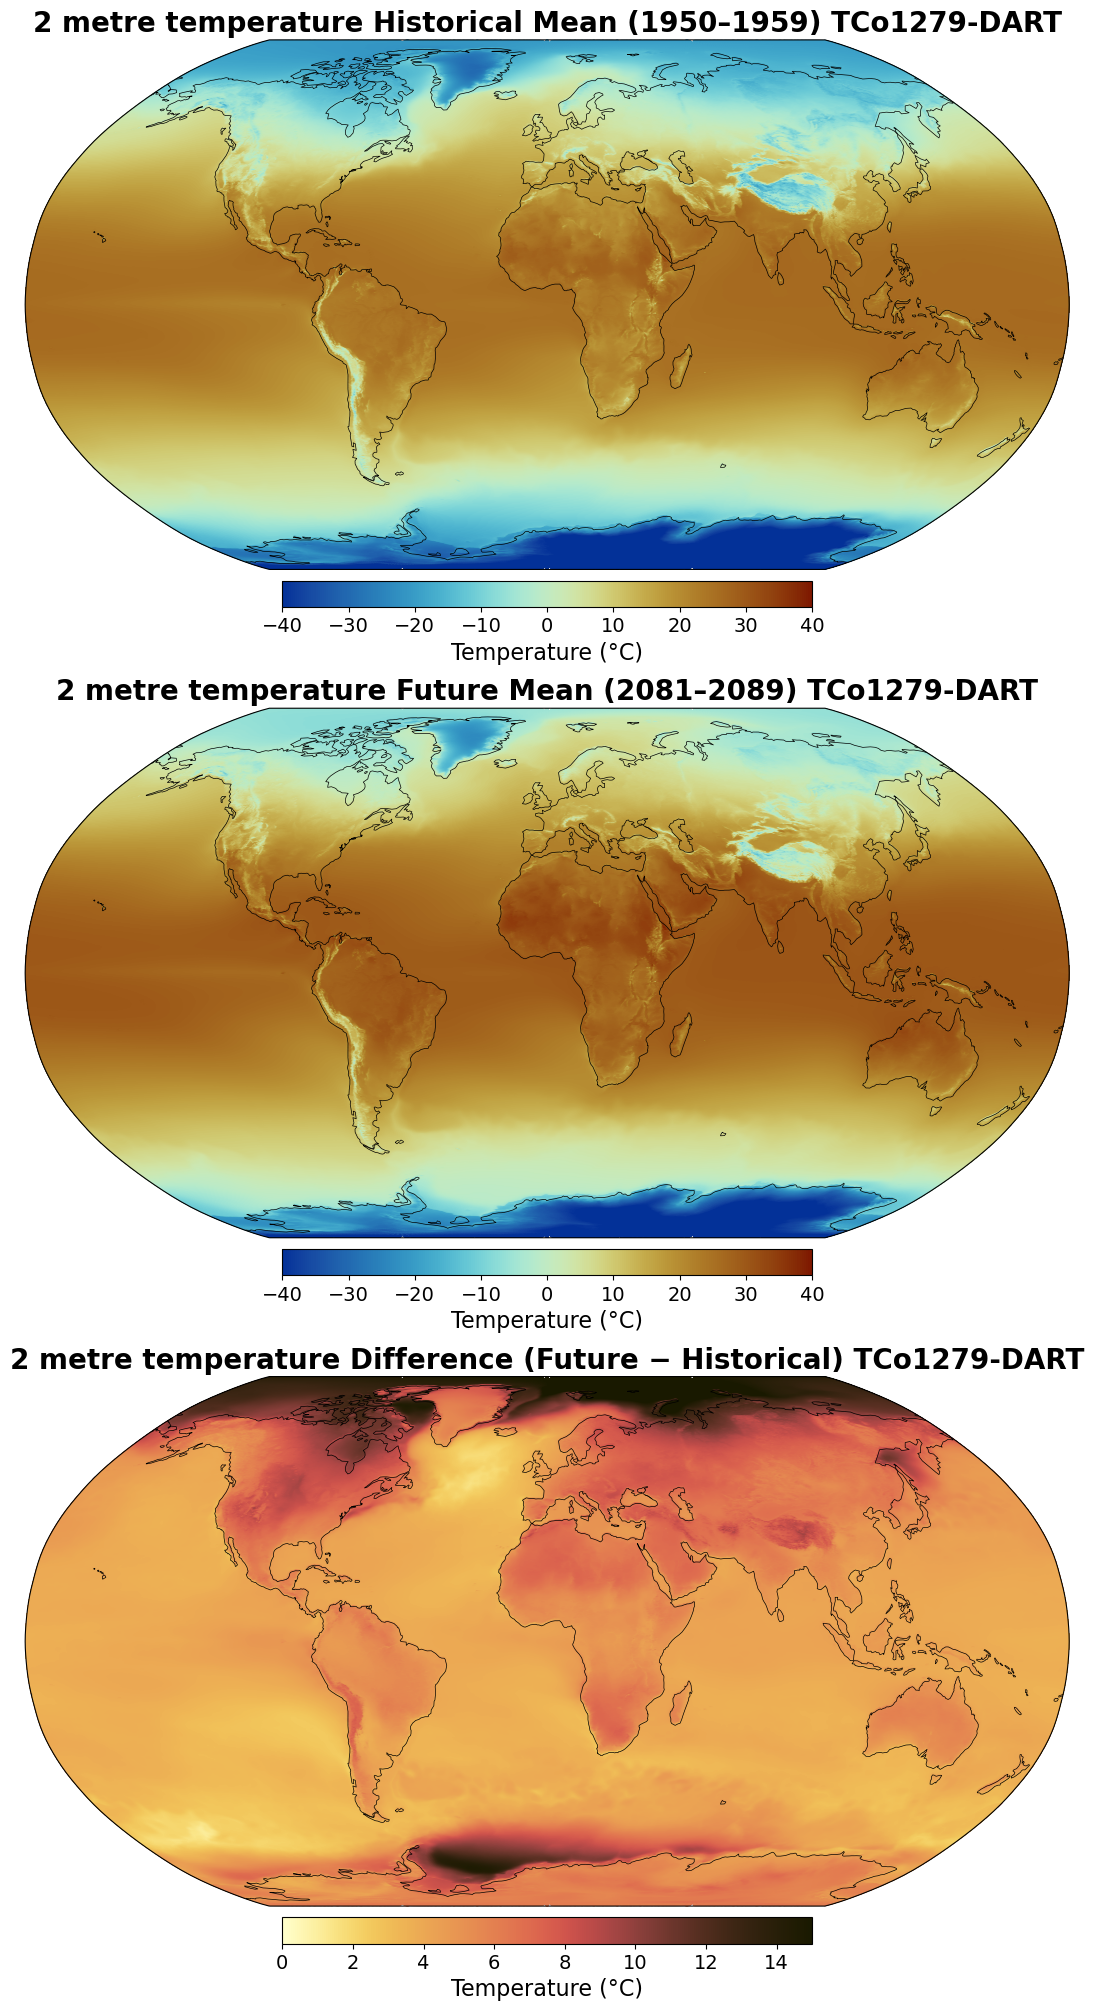

In [23]:
lat = da_mean_p['lat'].values
lon = da_mean_p['lon'].values

hist = da_mean_p.values-273
fut  = da_mean_f.values-273
diff = fut - hist

datasets = [hist, fut, diff]
c_ranges   = [(-40, 40), (-40, 40), (0, 15)]


titles = [
    f'{long_name} 1950CTL Mean (1950–1959) {expid}',
    f'{long_name} Future Mean (2080–2089) {expid}',
    f'{long_name} Difference (Future − Historical) {expid}'
]
fig, axes = plt.subplots(
    3, 1,
    figsize=(12, 20),
    subplot_kw={'projection': ccrs.Robinson()},
    constrained_layout=True
)

for ax, data, title, (vmin, vmax) in zip(axes, datasets, titles, c_ranges):
    ax.set_global()
    ax.coastlines(linewidth=0.5)

    sc = ax.scatter(
        lon,
        lat,
        c=data,
        s=1,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(),  
        cmap = cm.lajolla_r if "Difference" in title else cm.roma_r
    )

    ax.set_title(title, fontsize=20, fontweight='bold')

    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.02, shrink=0.75,fraction=0.05)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label("Temperature (°C)" if title != "Difference (Future − Historical)" else "ΔT (°C)",
                   size='16')

save_path = os.path.join(save_dir, "temperature2t_1279.png")


fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")  

plt.show()


## Cut region

Figure saved to: /mnt/lustre/proj/eunbyeol/Hackaton2025/step02_1279/temperature2t_Himalaya.png


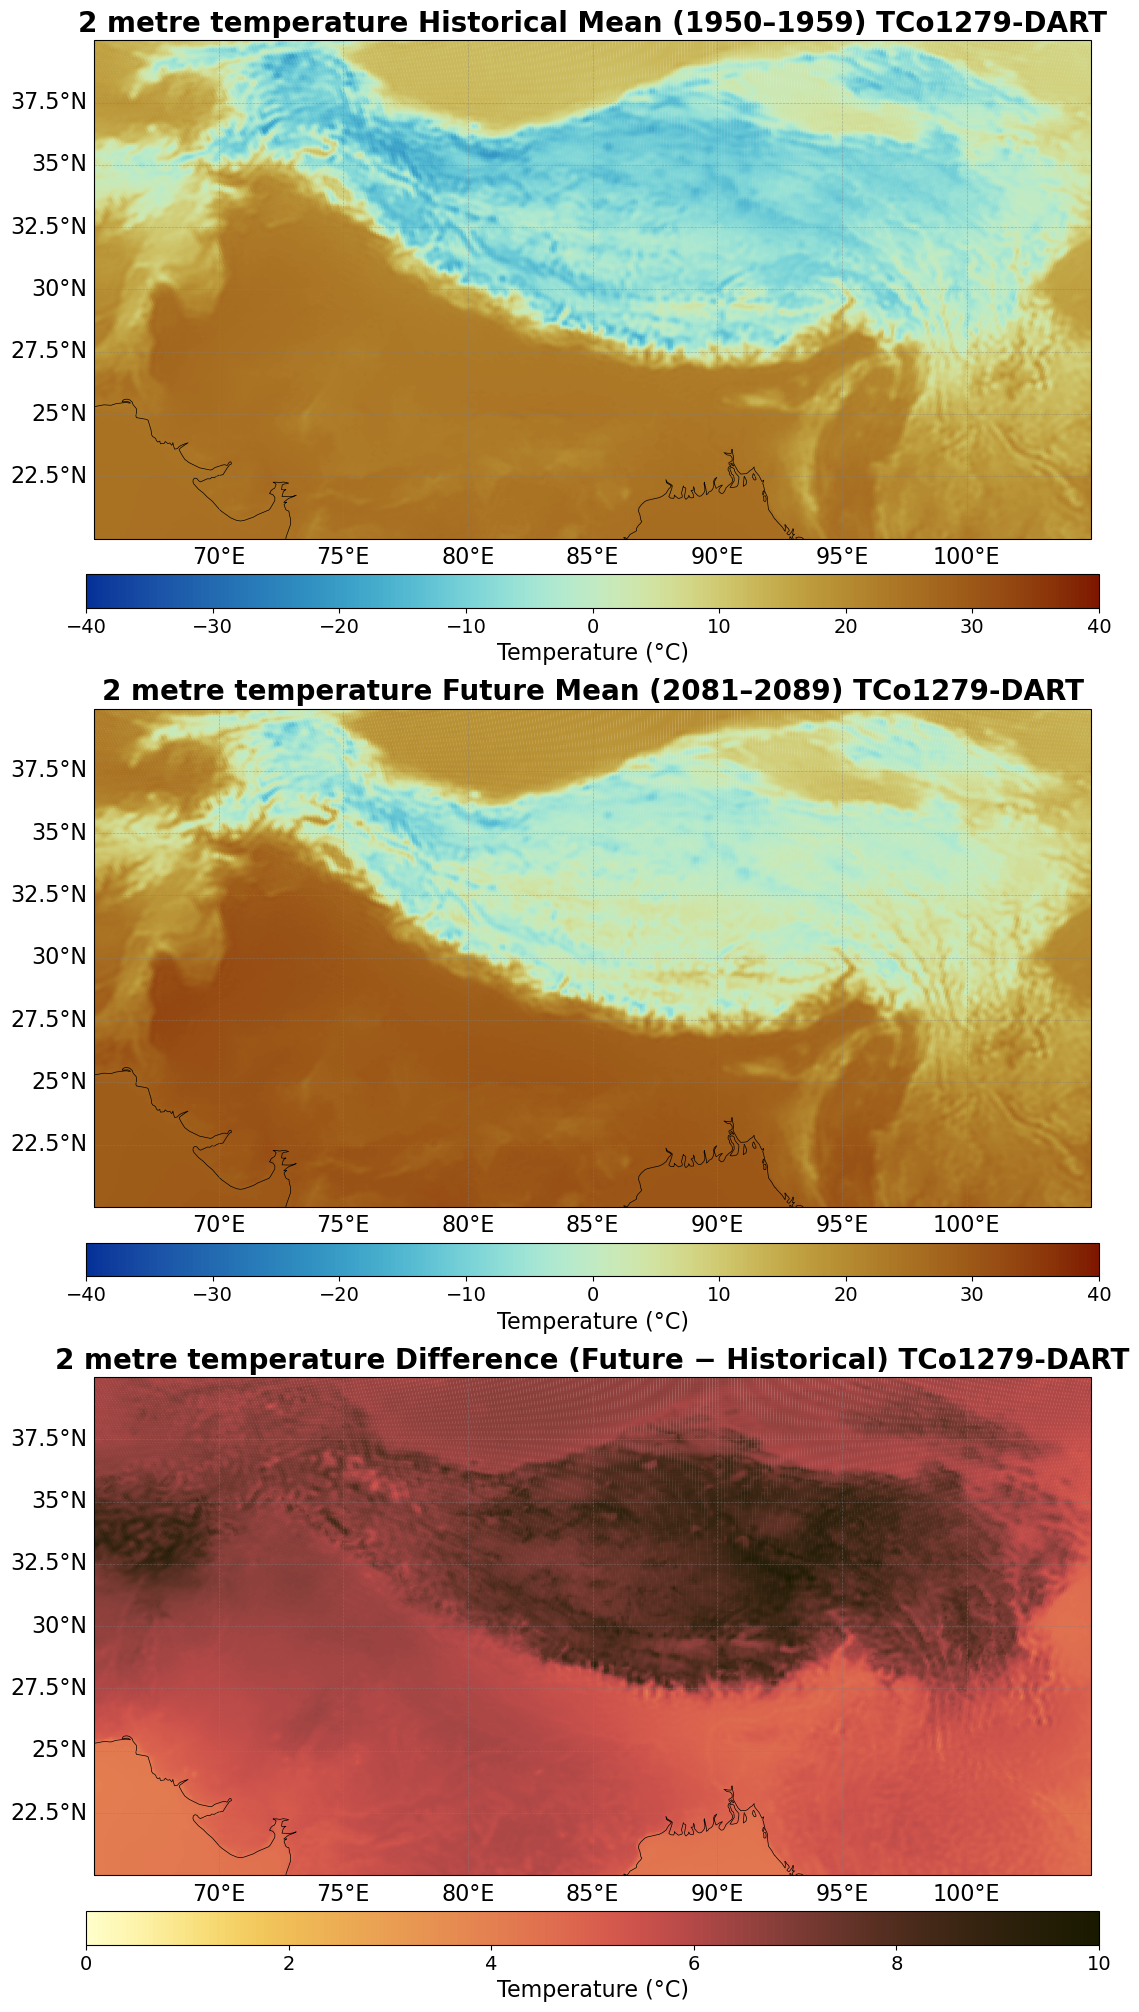

In [66]:
left, right = 65, 105
bottom, top = 20, 40
c_ranges   = [(-40, 40), (-40, 40), (0, 10)]
fig, axes = plt.subplots(
    3, 1,
    figsize=(12, 20),
    subplot_kw={'projection': ccrs.PlateCarree()},  
    constrained_layout=True
)

for ax, data, title, (vmin, vmax) in zip(axes, datasets, titles, c_ranges):
    ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())  # 영역 제한
    ax.coastlines(linewidth=0.5)

    sc = ax.scatter(
        lon,
        lat,
        c=data,
        s=2,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(),  
        cmap = cm.lajolla_r if "Difference" in title else cm.roma_r
    )

    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}

    ax.set_title(title, fontsize=20, fontweight='bold')

    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.01, shrink=0.85, fraction=0.1,aspect=30)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label("Temperature (°C)" if title != "Difference (Future − Historical)" else "ΔT (°C)",
                   size='16')

save_path = os.path.join(save_dir, "temperature2t_Himalaya.png")
fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")  

plt.show()


Figure saved to: /mnt/lustre/proj/eunbyeol/Hackaton2025/step02_1279/temperature2t_Alps.png


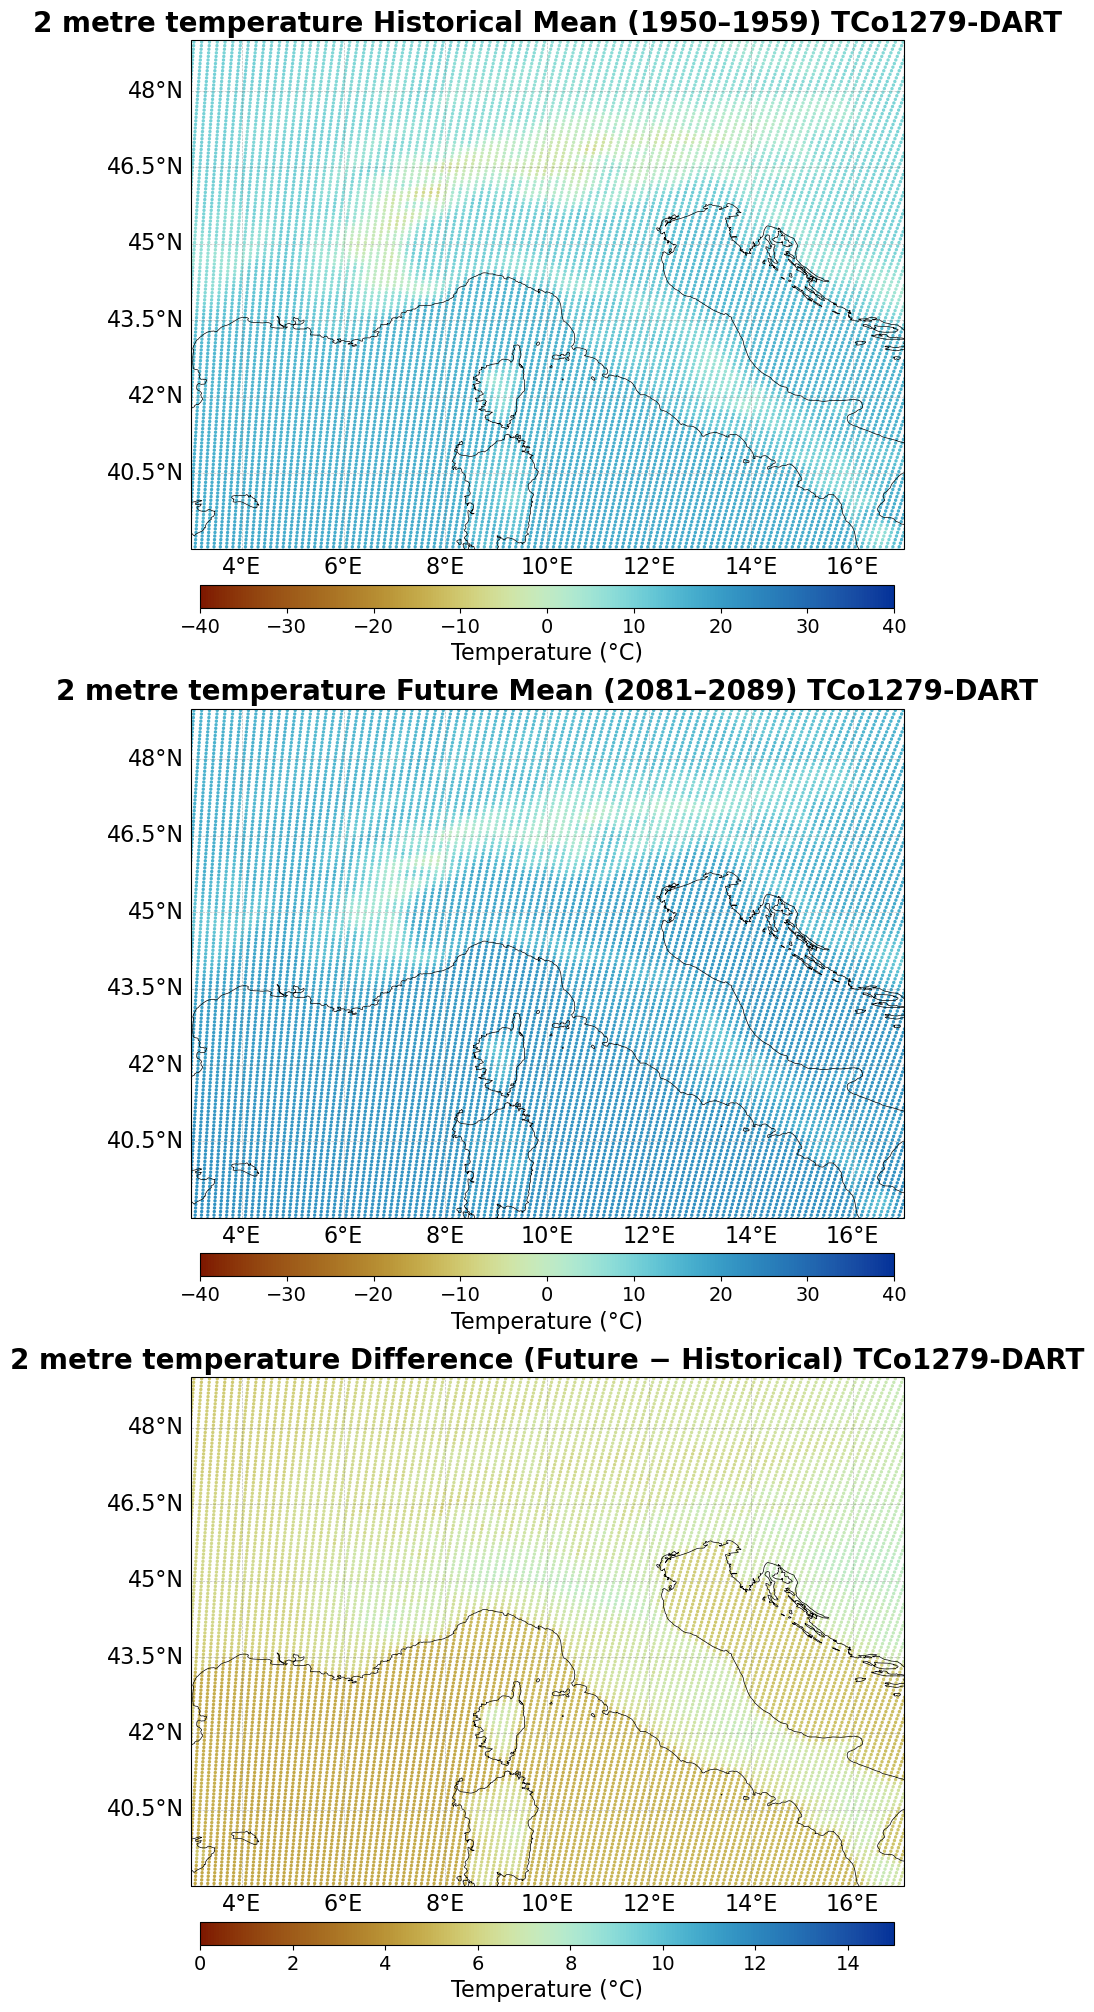

In [25]:
left, right = 3, 17
bottom, top = 39, 49

fig, axes = plt.subplots(
    3, 1,
    figsize=(10, 20),
    subplot_kw={'projection': ccrs.PlateCarree()},  
    constrained_layout=True
)

for ax, data, title, (vmin, vmax) in zip(axes, datasets, titles, c_ranges):
    ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())  # 영역 제한
    ax.coastlines(linewidth=0.5)

    sc = ax.scatter(
        lon,
        lat,
        c=data,
        s=2,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(),  
        cmap = cm.roma if title != "Difference (Future − Historical)" else cm.lajolla_r 
    )

    # 경도/위도 눈금 표시
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}

    ax.set_title(title, fontsize=20, fontweight='bold')

    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.01, shrink=0.70, fraction=0.1,aspect=30)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label("Temperature (°C)" if title != "Difference (Future − Historical)" else "ΔT (°C)",
                   size='16')

save_path = os.path.join(save_dir, "temperature2t_Alps.png")
fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")  

plt.show()


## Simple interpolation to a regular grid

In [26]:
# from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator

In [27]:
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator

In [60]:
# Alps
left, right = 3, 17
bottom, top = 39, 49

lon_geo = np.linspace(left, right, 400)
lat_geo = np.linspace(bottom, top, 400)
lon_geo2, lat_geo2 = np.meshgrid(lon_geo, lat_geo)


In [61]:
points = np.vstack((lon, lat)).T

In [62]:
%%time
nn_interpolation = NearestNDInterpolator(points, diff)

CPU times: user 2.12 s, sys: 0 ns, total: 2.12 s
Wall time: 2.11 s


In [63]:
Alps_interpolated_nn = nn_interpolation((lon_geo2, lat_geo2))

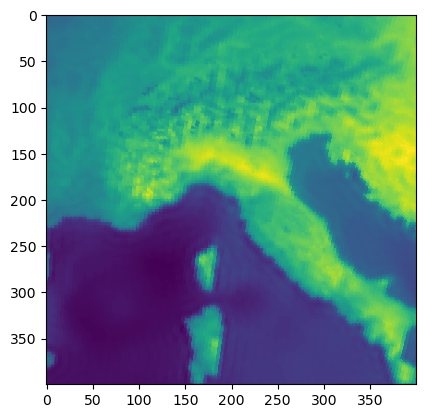

In [64]:
plt.imshow(np.flipud(Alps_interpolated_nn))

Figure saved to: /mnt/lustre/proj/eunbyeol/Hackaton2025/step02_1279/temperature2t_Alps_interpolated.png


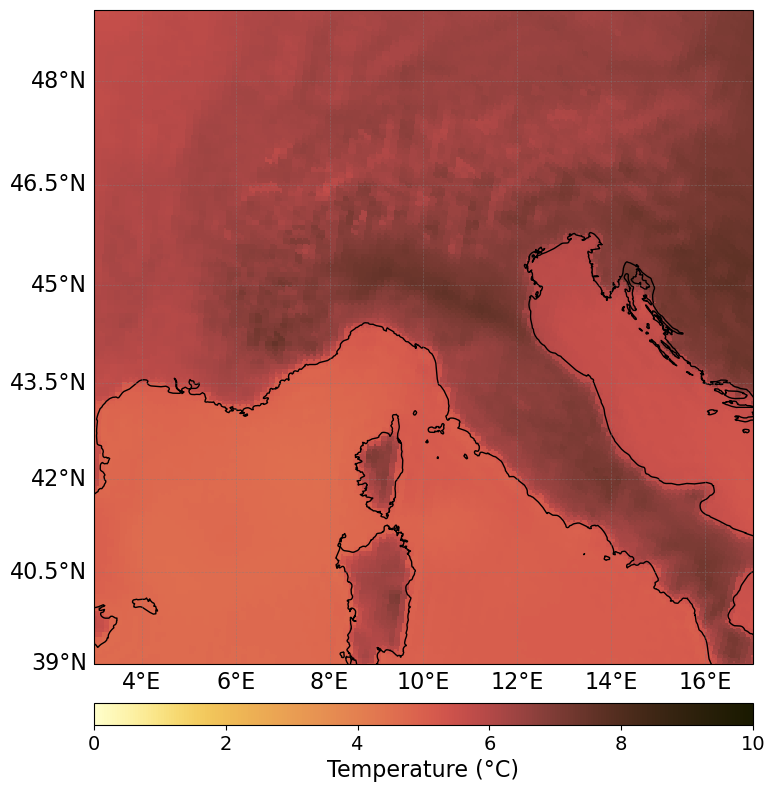

2025-12-01 10:38:28,175 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [65]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.Mercator()})

ax.coastlines(resolution='10m', color='k')

# pcolormesh
im = ax.pcolormesh(
    lon_geo, lat_geo, Alps_interpolated_nn,
    vmin=0, vmax=10,
    transform=ccrs.PlateCarree(),
    shading='auto',
    cmap=cm.lajolla_r
)

# 위경도 눈금
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

# colorbar
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.85, fraction=0.1, aspect=30)
cbar.ax.tick_params(labelsize=14)
cbar.set_label("Temperature (°C)", size=16)

save_path = os.path.join(save_dir, "temperature2t_Alps_interpolated.png")
fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")  

plt.show()

In [54]:
file_to_use = selected_files_p[0]  # 원하는 인덱스로 변경 가능
ds = xr.open_dataset(file_to_use)
var = ds[var_key]
long_name = var.attrs.get('long_name', var_key)

In [55]:
long_name

'2 metre temperature'

## Himalaya - interpolated

In [56]:
# Himalaya
left, right = 65, 105
bottom, top = 20, 40

lon_geo = np.linspace(left, right, 400)
lat_geo = np.linspace(bottom, top, 400)
lon_geo2, lat_geo2 = np.meshgrid(lon_geo, lat_geo)

points = np.vstack((lon, lat)).T

In [57]:
%%time
nn_interpolation = NearestNDInterpolator(points, diff)

CPU times: user 2.13 s, sys: 0 ns, total: 2.13 s
Wall time: 2.13 s


In [58]:
Himalaya_interpolated_nn = nn_interpolation((lon_geo2, lat_geo2))

Figure saved to: /mnt/lustre/proj/eunbyeol/Hackaton2025/step02_1279/temperature2t_Himalaya_interpolated.png


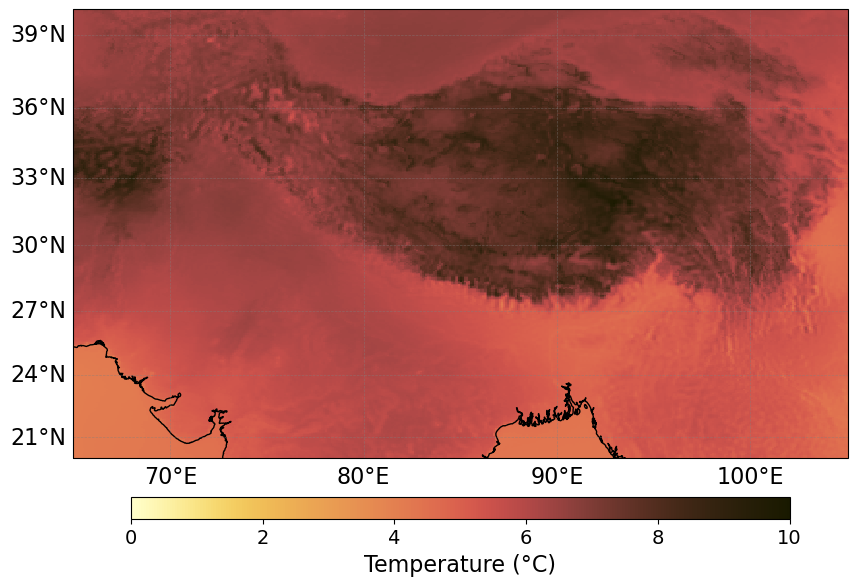

In [59]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.Mercator()})

ax.coastlines(resolution='10m', color='k')

# pcolormesh
im = ax.pcolormesh(
    lon_geo, lat_geo, Himalaya_interpolated_nn,
    vmin=0, vmax=10,
    transform=ccrs.PlateCarree(),
    shading='auto',
    cmap=cm.lajolla_r
)

# 위경도 눈금
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

# colorbar
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.85, fraction=0.1, aspect=30)
cbar.ax.tick_params(labelsize=14)
cbar.set_label("Temperature (°C)", size=16)

save_path = os.path.join(save_dir, "temperature2t_Himalaya_interpolated.png")
fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")  

plt.show()